In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import dill 
from matplotlib.pyplot import figure
from matplotlib.lines import Line2D
from scipy.stats import wilcoxon
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, KFold, cross_val_predict
from sklearn.metrics import roc_curve, auc, roc_auc_score, plot_roc_curve, confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay, classification_report, RocCurveDisplay
from sklearn.model_selection import StratifiedKFold

<font size="6">    <b>Probability over time</b>

Now we will attempt to fix this thing:
    
    - Extract the epoch and the data on which we will train then test the classifier
    - Extract the features on all the epochs and data of interest
    - Train the LDA with 70% of the features
    - Test the LDA with the other 30%

In [2]:
#pathe = '/Users/willy/Documents/GitHub/2021-fastReach/data/study/eeglab2python/3/\eeg.csv'
#pathm = '/Users/willy/Documents/GitHub/2021-fastReach/data/study/eeglab2python/3/\motion.csv'
#pathchan = '/Users/willy/Documents/GitHub/2021-fastReach/data/study/eeglab2python/3/\chans_rp-win_-1-0.csv'
#move = pd.read_csv('/Users/willy/Documents/GitHub/2021-fastReach/data/study/eeglab2python/3/\motion_onset_event_latencies.csv', header = None)
#move = move.values[0]

#chan = pd.read_csv(pathchan, header=None)
#eeg = pd.read_csv(pathe, header=None)
#velocity = pd.read_csv(pathm, header=None)

#pathemg = '/Users/willy/Documents/GitHub/2021-fastReach/data/study/eeglab2python/3/\emg.csv'
#emg = pd.read_csv(pathemg, header=None)

#np.save('eeg_3', eeg)
#np.save('velocity_3', velocity)
#np.save('emg_3', emg)

In [3]:
pathchan = '/Users/willy/Documents/GitHub/2021-fastReach/data/study/eeglab2python/5/\chans_rp-win_-1-0.csv'
chan = pd.read_csv(pathchan, header=None)
eeg = np.load('eeg_5.npy')
velocity = np.load('velocity_5.npy')
emg = np.load('emg_5.npy')
move = pd.read_csv('/Users/willy/Documents/GitHub/2021-fastReach/data/study/eeglab2python/5/\motion_onset_event_latencies.csv', header = None)
move = move.values[0]

In [4]:
# EEG channel selection
eeg_b = []
for i in chan.iloc[1:,0].astype(int)-1:  
    eeg_b.append(eeg[i,:])
eeg_b = np.asarray(eeg_b)


# Baseline corection
emg[1,:] = emg[1,:] - emg[1,0]
emg[0,:] = emg[0,:] - emg[0,0]


<font size="3">    <b>Velocity: Extraction of area of interest</b>

In [5]:
# The first and last onsets do not have enough samples before or after to get a proper frame extraction.
fs = 250

before = fs * 2 +1
after  = fs * 1//2

velo   = np.zeros((len(move), (before + after)))

for k in range(len(move)):
    
        velo[k, :(before + after)] = velocity[0, move[k] - before : move[k] + after]

<font size="3" color='blue'>    <b>EMG: Epochs extraction and extraction of area of interest</b>

In [6]:
# Number of sample before and after movement onset
idleb_emg   = fs * 6
idlea_emg   = fs * (-5)

intentb_emg = fs
intenta_emg = 0

interb_emg  = fs * 3     # ALWAYS TAKE 250 SAMPLES MORE BEFORE THE DESIRED START
intera_emg  = after

# Let's create matrices with row = epoch, columns = epoch duration and 3D = nb_chan
idle_emg    = np.zeros((len(move), (idleb_emg + idlea_emg),    emg.shape[0]))      # Idle period
intent_emg  = np.zeros((len(move), (intentb_emg + intenta_emg),emg.shape[0]))      # Intention period
inter_emg   = np.zeros((len(move), (interb_emg + intera_emg),  emg.shape[0]))      # Period of interest

for k in range(len(move)):
   
    for j in range(emg.shape[0]):
    
        idle_emg[k, 0:(idleb_emg + idlea_emg), j]       = emg[j, move[k] - idleb_emg : move[k] + idlea_emg]
        intent_emg[k, 0:(intentb_emg + intenta_emg), j] = emg[j, move[k] - intentb_emg : move[k] + intenta_emg]
        inter_emg[k, 0:(interb_emg + intera_emg), j]    = emg[j, move[k] - interb_emg : move[k] + intera_emg]

In [7]:
def rms(values):
    return np.sqrt(sum(values**2)/len(values))

def mini(values):
    return np.min(values)

def maxi(values):
    return np.max(values)

def mav(values):
    return np.mean(abs(values))

def var(values):
    return np.var(values)

feat_list = [rms, mini, maxi, mav, var]

<font size="3" color='blue'>    <b>Extract the features for idle and intent</b>
    
10 features per onset.

In [8]:
win = 250
sld_size = 1

feat_idle   = np.zeros((len(move), emg.shape[0]*len(feat_list)))
feat_intent = np.zeros((len(move), emg.shape[0]*len(feat_list)))                  

for k in range(len(move)):              # Index of the onset
   
    for j in range(emg.shape[0]):    # Index of the channel
        
        for i in range(len(feat_list)): # Index of the feature
        
            feat_idle[k, i +(5*j)]   = np.apply_along_axis(feat_list[i], 0, idle_emg[k, :, j])
            feat_intent[k, i +(5*j)] = np.apply_along_axis(feat_list[i], 0, intent_emg[k, :, j])

<font size="3" color='blue'>    <b>Extract the features on period of interest with a sliding window</b>

In [9]:
feat_inter = np.zeros((len(move), emg.shape[0]*len(feat_list), (inter_emg.shape[1]//sld_size) - fs + sld_size))

for k in range(len(move)):                  # Index of the onset
    
    for l in range(feat_inter.shape[2]):    # Index of the slide
   
        for j in range(emg.shape[0]):    # Index of the channel
        
            for i in range(len(feat_list)): # Index of the feature
        
                feat_inter[k, i +(5*j), l] = np.apply_along_axis(feat_list[i], 0, 
                                                                 inter_emg[k, (sld_size*l):win+(sld_size*l), j])
        

<font size="3" color='blue'>    <b>DataFrame and LDA training</b>

In [10]:
test   = (len(move)*70)//100
idle_emg   = pd.concat([pd.DataFrame(feat_idle), pd.DataFrame(np.zeros((150)))], axis=1, keys={'features', 'class'})
intent_emg = pd.concat([pd.DataFrame(feat_intent), pd.DataFrame(np.ones((150)))], axis=1, keys={'features', 'class'})

df_emg_train = pd.concat([idle_emg.iloc[:test,:], intent_emg.iloc[:test,:]], axis=0) # Only train on 110 first epochs

In [11]:
(len(move)*70)//100

112

In [12]:
Xemg = df_emg_train.iloc[:, :10].values
yemg = df_emg_train.iloc[:, 10].values

clf_emg = LDA(solver='lsqr', shrinkage='auto')

clf_emg.fit(Xemg, yemg)

# splits data randomly in n=folds 
kfolds = KFold(n_splits=10, random_state=1, shuffle=True) 

cv_results = cross_val_score(clf_emg, Xemg, yemg, cv=kfolds)
cv_average = cv_results.mean()
st_deviation = cv_results.std()
print(cv_average)
print(st_deviation)

0.7262845849802371
0.1040406380872576


<font size="3" color='blue'>    <b>Probability extraction</b>

In [13]:
proba_emg = np.zeros((len(move)-test, feat_inter.shape[2]))

for k in range(len(move)-test):
    
    for l in range(feat_inter.shape[2]):
        
        proba_emg[k, l] = clf_emg.predict_proba(feat_inter[-k, :, l].reshape(1, -1))[0][1]

<font size="3" color='blue'>    <b>DataFrame including Time, Velocity and Proba</b>

In [14]:
time = np.arange(-2-1/fs, 1/2, 1/fs)                       # Define time axis
m_time = np.tile(time, (1, len(move)-test)).transpose()
f_time = np.reshape(m_time, len(m_time))

f_proba_emg = np.reshape(proba_emg, len(f_time))

m_velo = velo[test:, :]
f_velocity = np.reshape(m_velo, len(f_time))

f_data_emg = np.zeros((len(f_time), 3))
f_data_emg[:,0] = f_time
f_data_emg[:,1] = f_velocity * 1000
f_data_emg[:,2] = f_proba_emg
final_emg = pd.DataFrame(f_data_emg, columns=['Time', 'Velocity', 'Probability'])
final_emg

,Time,Velocity,Probability
0,-2.004,0.012552,0.470785
1,-2.000,0.015002,0.471738
2,-1.996,0.017420,0.472454
3,-1.992,0.019431,0.473444
4,-1.988,0.021199,0.473725
...,...,...,...
30669,0.480,2.025205,0.970105
30670,0.484,1.998961,0.969321
30671,0.488,1.972050,0.969504
30672,0.492,1.944105,0.969516


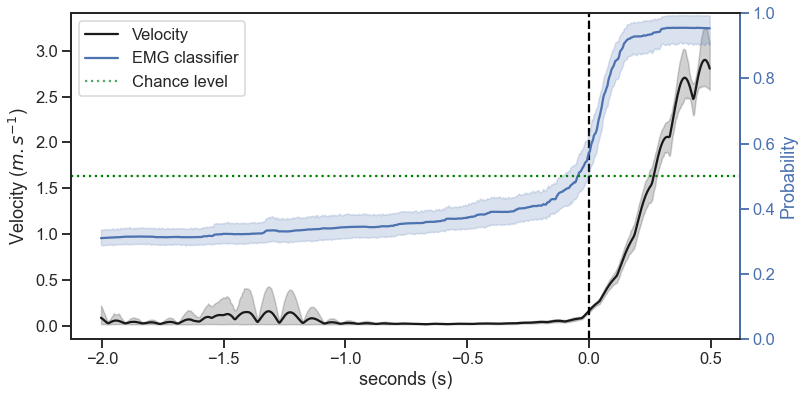

In [15]:
figure(figsize=(12, 6))

# Velocity
sns.set_theme(context='talk', style='ticks')
ep_move = sns.lineplot(data=final_emg, x='Time', y='Velocity', color='k', legend=False)

ep_move.set(xlabel='seconds (s)', ylabel="Velocity ($m.s^{-1}$)")

# Movement onset
plt.axvline(0, color='black', label = 'onset', linestyle ='--')

# Probability
ax2 = plt.twinx()
ax2.set_ylabel('Probability', color='b')
ax2.spines['right'].set_color('b')
ax2.tick_params(axis='y', colors='b')
ep_prob = sns.lineplot(data=final_emg, x='Time', y='Probability', ax=ax2, color='b', legend=False)
plt.ylim((0,1))
plt.axhline(0.5, color='green', label = 'onset', linestyle ='dotted')

# legend
ep_prob.legend(loc='upper left', handles=[Line2D([], [], marker='_', color="k", label='Velocity'), 
                                          Line2D([], [], marker='_', color="b", label='EMG classifier'),
                                          Line2D([], [], linestyle ='dotted', color="g", label='Chance level')])

<font size="3" color='red'>    <b>EEG: Epochs extraction and extraction of area of interest</b>

In [16]:
# Number of sample before and after movement onset
idleb_eeg   = fs * 6
idlea_eeg   = fs * (-5)

intentb_eeg = fs
intenta_eeg = 0

interb_eeg  = fs * 3
intera_eeg  = after

# Let's create matrices with row = epoch, columns = epoch duration and 3D = nb_chan
idle_eeg    = np.zeros((len(move), (idleb_eeg + idlea_eeg),    eeg_b.shape[0]))      # Idle period
intent_eeg  = np.zeros((len(move), (intentb_eeg + intenta_eeg),eeg_b.shape[0]))      # Intention period
inter_eeg   = np.zeros((len(move), (interb_eeg + intera_eeg),  eeg_b.shape[0]))      # Period of interest

for k in range(len(move)):
   
    for j in range(eeg_b.shape[0]):
    
        idle_eeg[k, 0:(idleb_eeg + idlea_eeg), j]       = eeg_b[j, move[k] - idleb_eeg : move[k] + idlea_eeg]
        intent_eeg[k, 0:(intentb_eeg + intenta_eeg), j] = eeg_b[j, move[k] - intentb_eeg : move[k] + intenta_eeg]
        inter_eeg[k, 0:(interb_eeg + intera_eeg), j]    = eeg_b[j, move[k] - interb_eeg : move[k] + intera_eeg]

<font size="3" color='red'>    <b>Feature extration on idle and intent</b>

In [17]:
win       = 250
sld_size  = 1
feat_size = 25
n_feat    = win//feat_size

feat_idle_eeg   = np.zeros((len(move), eeg_b.shape[0]*n_feat))
feat_intent_eeg = np.zeros((len(move), eeg_b.shape[0]*n_feat))                  

for k in range(len(move)):              # Index of the onset
   
    for j in range(eeg_b.shape[0]):     # Index of the channel
        
        for i in range(n_feat):         # Index of the feature
        
            feat_idle_eeg[k, i +(n_feat*j)]   = np.mean(idle_eeg[k, (feat_size*i):feat_size + (feat_size*i), j])
            feat_intent_eeg[k, i +(n_feat*j)] = np.mean(intent_eeg[k, (feat_size*i):feat_size + (feat_size*i), j])

<font size="3" color='red'>    <b>Feature extraction on area on interest with sliding window</b>

In [18]:
feat_inter_eeg = np.zeros((len(move), eeg_b.shape[0]*n_feat, (inter_eeg.shape[1]//sld_size) - fs + sld_size))

for k in range(len(move)):                   # Index of the onset
    
    for l in range(feat_inter_eeg.shape[2]): # Index of the slide
   
        for j in range(eeg_b.shape[0]):      # Index of the channel
            
            for i in range(n_feat):          # Index of the feature
        
                feat_inter_eeg[k, i +(n_feat*j), l] = np.mean(inter_eeg[k, 
                                                  (feat_size*i)+(sld_size*l):feat_size + 
                                                  (feat_size*i)+(sld_size*l), j])


<font size="3" color='red'>    <b>Baseline correction CHECK THIS AGAIN WITH FRESH BRAIN</b>

In [19]:
#Correct the baseline after mean feature extraction, I think it should work that way
idle_cor   = np.zeros((feat_idle_eeg.shape))
intent_cor = np.zeros((feat_intent_eeg.shape))
inter_cor  = np.zeros((feat_inter_eeg.shape))

for k in range(len(move)):
    
    for j in range(eeg_b.shape[0]):
    
        idle_cor[k, (10*j):10+(10*j)]   = feat_idle_eeg[k, (10*j):10+(10*j)] - idle_eeg[k, 0, j]
        intent_cor[k, (10*j):10+(10*j)] = feat_intent_eeg[k, (10*j):10+(10*j)] - intent_eeg[k, 0, j]
            
        for l in range(feat_inter_eeg.shape[2]):
            
            inter_cor[k, (10*j):10+(10*j), l] = feat_inter_eeg[k, (10*j):10+(10*j), l] - inter_eeg[k, l, j]
        

<font size="3" color='red'>    <b>DataFrames</b>

In [20]:
test   = (len(move)*70)//100
idle_eeg   = pd.concat([pd.DataFrame(idle_cor), pd.DataFrame(np.zeros((150)))], axis=1, keys={'features', 'class'})
intent_eeg = pd.concat([pd.DataFrame(intent_cor), pd.DataFrame(np.ones((150)))], axis=1, keys={'features', 'class'})

df_eeg_train = pd.concat([idle_eeg.iloc[:test,:], intent_eeg.iloc[:test,:]], axis=0) 

<font size="3" color='red'>    <b>Classifier training</b>

In [21]:
Xeeg = df_eeg_train.iloc[:, :-1].values
yeeg = df_eeg_train.iloc[:, -1].values

clf_eeg = LDA(solver='lsqr', shrinkage='auto')

clf_eeg.fit(Xeeg, yeeg)

# splits data randomly in n=folds 
kfolds = KFold(n_splits=10, random_state=1, shuffle=True) 

cv_results = cross_val_score(clf_eeg, Xeeg, yeeg, cv=kfolds)
cv_average = cv_results.mean()
st_deviation = cv_results.std()
print(cv_average)
print(st_deviation)

0.6079051383399209
0.056971866392813424


<font size="3" color='red'>    <b>Probability testing</b>

In [22]:
proba_eeg = np.zeros((len(move)-test, feat_inter_eeg.shape[2]))

for k in range(len(move)-test):
    
    for l in range(feat_inter_eeg.shape[2]):
        
        proba_eeg[k, l] = clf_eeg.predict_proba(inter_cor[-k, :, l].reshape(1, -1))[0][1]

<font size="3" color='red'>    <b>DataFrame, Velocity, Proba</b>

In [23]:
time = np.arange(-2-1/fs, 1/2, 1/fs)                       # Define time axis
m_time = np.tile(time, (1, len(move)-test)).transpose()
f_time = np.reshape(m_time, len(m_time))

f_proba_eeg = np.reshape(proba_eeg, len(f_time))

m_velo = velo[test:, :]
f_velocity = np.reshape(m_velo, len(f_time))

f_data_eeg = np.zeros((len(f_time), 3))
f_data_eeg[:,0] = f_time
f_data_eeg[:,1] = f_velocity * 1000
f_data_eeg[:,2] = f_proba_eeg
final_eeg = pd.DataFrame(f_data_eeg, columns=['Time', 'Velocity', 'Probability'])
final_eeg

,Time,Velocity,Probability
0,-2.004,0.012552,0.953250
1,-2.000,0.015002,0.970844
2,-1.996,0.017420,0.975646
3,-1.992,0.019431,0.957860
4,-1.988,0.021199,0.932627
...,...,...,...
30669,0.480,2.025205,0.820500
30670,0.484,1.998961,0.839221
30671,0.488,1.972050,0.907465
30672,0.492,1.944105,0.928083


<font size="3" color='red'>    <b>Plot</b>

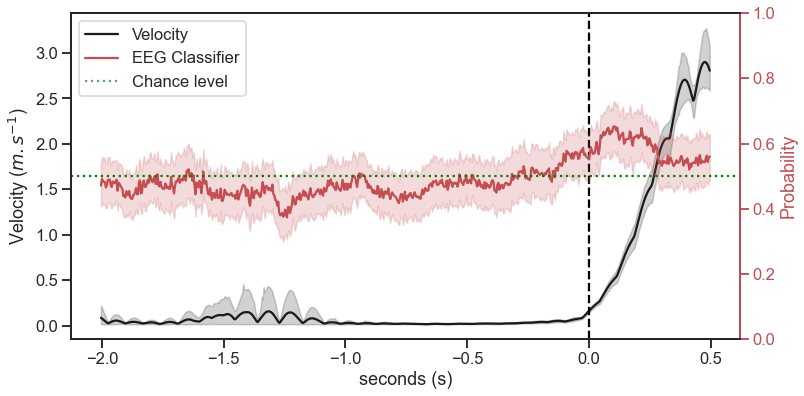

In [24]:
figure(figsize=(12, 6))

# Velocity
sns.set_theme(context='talk', style='ticks')
ep_move = sns.lineplot(data=final_eeg, x='Time', y='Velocity', color='k', legend=False)

ep_move.set(xlabel='seconds (s)', ylabel="Velocity ($m.s^{-1}$)")

# Movement onset
plt.axvline(0, color='black', label = 'onset', linestyle ='--')

# Probability
ax2 = plt.twinx()
ax2.set_ylabel('Probability', color='r')
ax2.spines['right'].set_color('r')
ax2.tick_params(axis='y', colors='r')
ep_prob = sns.lineplot(data=final_eeg, x='Time', y='Probability', ax=ax2, color='r', legend=False)
plt.ylim((0,1))

plt.axhline(0.5, color='green', label = 'onset', linestyle ='dotted')

# legend
ep_prob.legend(loc='upper left', handles=[Line2D([], [], marker='_', color="k", label='Velocity'), 
                                          Line2D([], [], marker='_', color="r", label='EEG Classifier'),
                                          Line2D([], [], linestyle ='dotted', color="g", label='Chance level')])

<font size="3" color='purple'>    <b>Merge for EEG_EMG</b>

In [25]:
idle_eeg_emg   = np.concatenate((feat_idle, idle_cor), axis=1)
intent_eeg_emg = np.concatenate((feat_intent, intent_cor), axis=1)

inter_eeg_emg  = np.concatenate((feat_inter, inter_cor), axis=1)

test   = (len(move)*70)//100
idle   = pd.concat([pd.DataFrame(idle_eeg_emg), pd.DataFrame(np.zeros((150)))], axis=1, keys={'features', 'class'})
intent = pd.concat([pd.DataFrame(intent_eeg_emg), pd.DataFrame(np.ones((150)))], axis=1, keys={'features', 'class'})

df_eeg_emg_train = pd.concat([idle.iloc[:test,:], intent.iloc[:test,:]], axis=0) 

<font size="3" color='purple'>    <b>Classifier</b>

In [26]:
Xeeg_emg = df_eeg_emg_train.iloc[:, :-1].values
yeeg_emg = df_eeg_emg_train.iloc[:, -1].values

clf_eeg_emg = LDA(solver='lsqr', shrinkage='auto')

clf_eeg_emg.fit(Xeeg_emg, yeeg_emg)

# splits data randomly in n=folds 
kfolds = KFold(n_splits=10, random_state=1, shuffle=True) 

cv_results = cross_val_score(clf_eeg_emg, Xeeg_emg, yeeg_emg, cv=kfolds)
cv_average = cv_results.mean()
st_deviation = cv_results.std()
print(cv_average)
print(st_deviation)

0.7318181818181818
0.08943664917240857


<font size="3" color='purple'>    <b>Proba</b>

In [27]:
proba_eeg_emg = np.zeros((len(move)-test, feat_inter_eeg.shape[2]))

for k in range(len(move)-test):
    
    for l in range(feat_inter_eeg.shape[2]):
        
        proba_eeg_emg[k, l] = clf_eeg_emg.predict_proba(inter_eeg_emg[-k, :, l].reshape(1, -1))[0][1]

<font size="3" color='purple'>    <b>DataFrame</b>

In [28]:
time = np.arange(-2-1/fs, 1/2, 1/fs)                     # Define time axis
m_time = np.tile(time, (1, len(move)-test)).transpose()
f_time = np.reshape(m_time, len(m_time))

f_proba_eeg_emg = np.reshape(proba_eeg_emg, len(f_time))

m_velo = velo[test:, :]
f_velocity = np.reshape(m_velo, len(f_time))

f_data_eeg_emg = np.zeros((len(f_time), 3))
f_data_eeg_emg[:,0] = f_time
f_data_eeg_emg[:,1] = f_velocity * 1000
f_data_eeg_emg[:,2] = f_proba_eeg_emg
final_eeg_emg = pd.DataFrame(f_data_eeg_emg, columns=['Time', 'Velocity', 'Probability'])
final_eeg_emg

,Time,Velocity,Probability
0,-2.004,0.012552,0.967359
1,-2.000,0.015002,0.981230
2,-1.996,0.017420,0.982219
3,-1.992,0.019431,0.968837
4,-1.988,0.021199,0.951350
...,...,...,...
30669,0.480,2.025205,0.997849
30670,0.484,1.998961,0.998107
30671,0.488,1.972050,0.999095
30672,0.492,1.944105,0.999338


<font size="3" color='purple'>    <b>Plot</b>

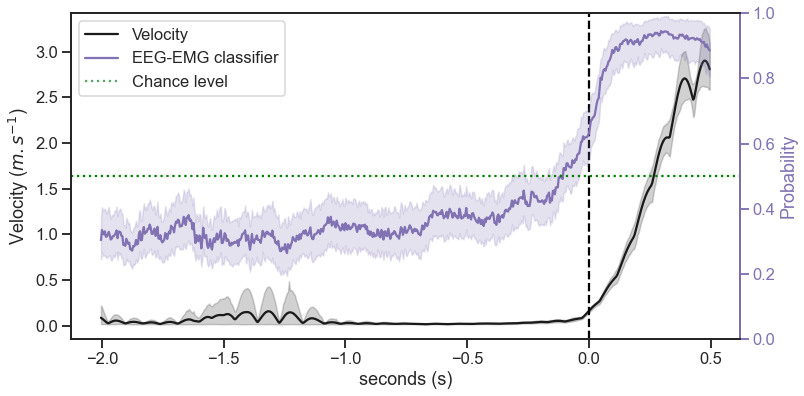

In [29]:
figure(figsize=(12, 6))

# Velocity
sns.set_theme(context='talk', style='ticks')
ep_move = sns.lineplot(data=final_eeg_emg, x='Time', y='Velocity', color='k', legend=False)

ep_move.set(xlabel='seconds (s)', ylabel="Velocity ($m.s^{-1}$)")

# Movement onset
plt.axvline(0, color='black', label = 'onset', linestyle ='--')

# Probability
ax2 = plt.twinx()
ax2.set_ylabel('Probability', color='m')
ax2.spines['right'].set_color('m')
ax2.tick_params(axis='y', colors='m')
ep_prob = sns.lineplot(data=final_eeg_emg, x='Time', y='Probability', ax=ax2, color='m', legend=False)
plt.ylim((0,1))
plt.axhline(0.5, color='green', label = 'onset', linestyle ='dotted')

# legend
ep_prob.legend(loc='upper left', handles=[Line2D([], [], marker='_', color="k", label='Velocity'), 
                                          Line2D([], [], marker='_', color="m", label='EEG-EMG classifier'),
                                          Line2D([], [], linestyle ='dotted', color="g", label='Chance level')])